In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import SCCircuit
from dsn.util.dsn_util import get_savedir, get_system_from_template, \
                              get_arch_from_template, get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot, plot_var_ellipse, plot_target_ellipse
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
import os



In [2]:
os.chdir('../../')

In [3]:
EPS = 1e-16

ps = [0.5, 0.6, 0.7, 0.8, 0.9]
inact_str = "NI"

dirstr = 'SC_WTA_%s/' % inact_str

# normalizing flow layer architecture
flow_type = 'PlanarFlow'
# number of layers
nlayers = 10
mult_and_shift = 'post'

lr_order = -3

In [4]:
# multivariate normal initialization variance
c_init_ords = np.array([2])
sigma_inits = np.array([1.0])
start_rs = 1
num_rs = 10
random_seeds = np.arange(start_rs, start_rs+num_rs)


In [5]:
best_models = []
ME_its = []

alpha=0.05
frac_samps=0.5
std = 0.15
var = std**2
N = 500
               
for p in ps:

    param_dict = {
        "behavior_type":"WTA",
        "p":p,
        "var":var,
        "inact_str":inact_str,
        "N":N,
    }
    system = get_system_from_template('SCCircuit', param_dict)

    arch_dict = {'K': 1, \
                 'D':system.D, \
                 'post_affine':True, \
                 'flow_type':flow_type, \
                 'sigma_init':1.0,
                 'repeats':nlayers}
    
    ptol = 0.02
    contol = 0.05
    if (p==1.0):
        tol = np.array([ptol, ptol, ptol, ptol, contol, contol, contol, contol])
        tol_inds = [0,1,2,3,4,5,6,7]
    else:
        tol = contol*np.ones((4,))
        tol_inds = [4,5,6,7]

    conv_dict = {
        'alpha':alpha,
        'frac_samples':frac_samps,
        'tol':tol,
        'tol_inds':tol_inds
    }
    print('p', p)
    best_model, max_ME, ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, 
                                                       random_seeds, dirstr, 
                                                       conv_dict)
    print(max_ME, ME_it, first_it)
    best_models.append(best_model)
    ME_its.append(ME_it)

p 0.5
16.165272711375856 3 3
p 0.6
14.306725069784779 11 11
p 0.7
14.218070978236883 6 6
p 0.8
14.309207229249735 5 5
p 0.9
no file models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=9.00E-01_9.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=7/opt_info.npz
9.868123825075635 10 10


Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x12d695278>>
Traceback (most recent call last):
  File "/Users/sbittner/anaconda/envs/dsn/lib/python3.6/site-packages/numpy/lib/npyio.py", line 226, in __del__
    self.close()
  File "/Users/sbittner/anaconda/envs/dsn/lib/python3.6/site-packages/numpy/lib/npyio.py", line 217, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


In [6]:
for i in range(len(ps)):
    print(best_models[i])
print(ME_its)

models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=8/
models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=6.00E-01_6.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=7/
models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=7.00E-01_7.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=5/
models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=8.00E-01_8.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=7/
models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=9.00E-01_9.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=8/
[array(3), array(11), array(6), array(5), array(10)]


ticks None
0
dist (300, 8)
not saving figure
1
dist (300, 8)
not saving figure
2
dist (300, 8)
not saving figure
3
dist (300, 8)
not saving figure
4
dist (300, 8)
not saving figure


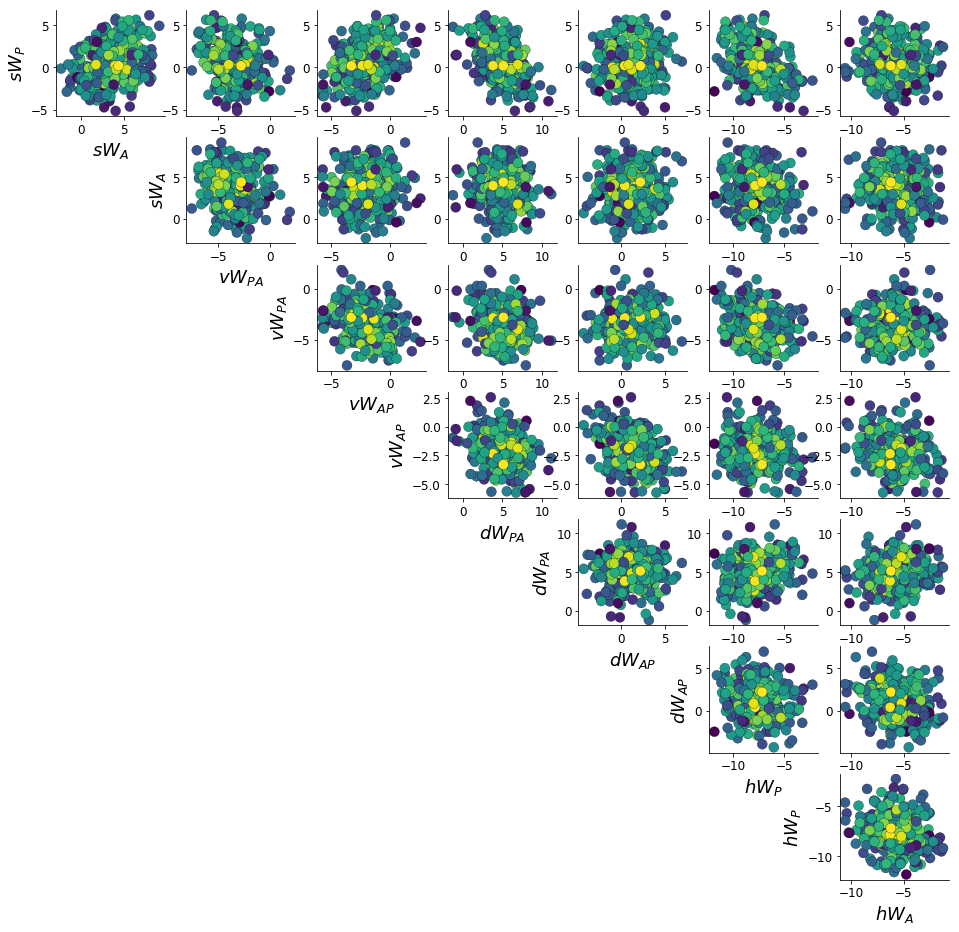

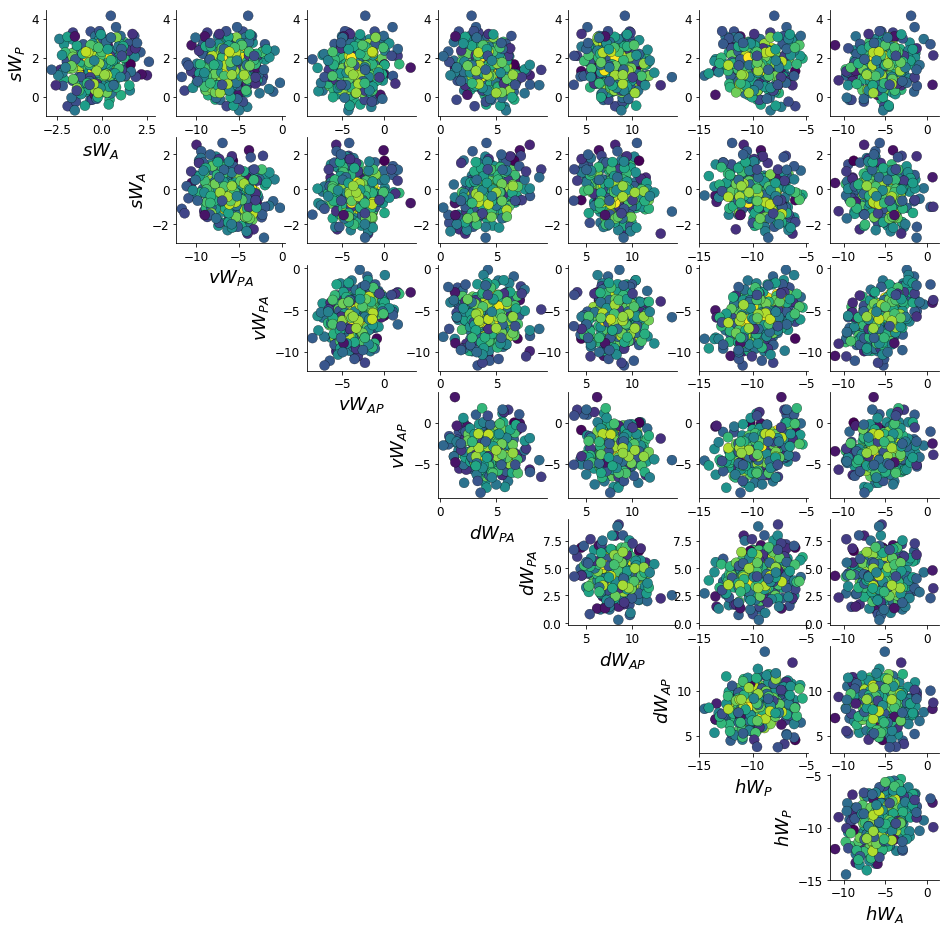

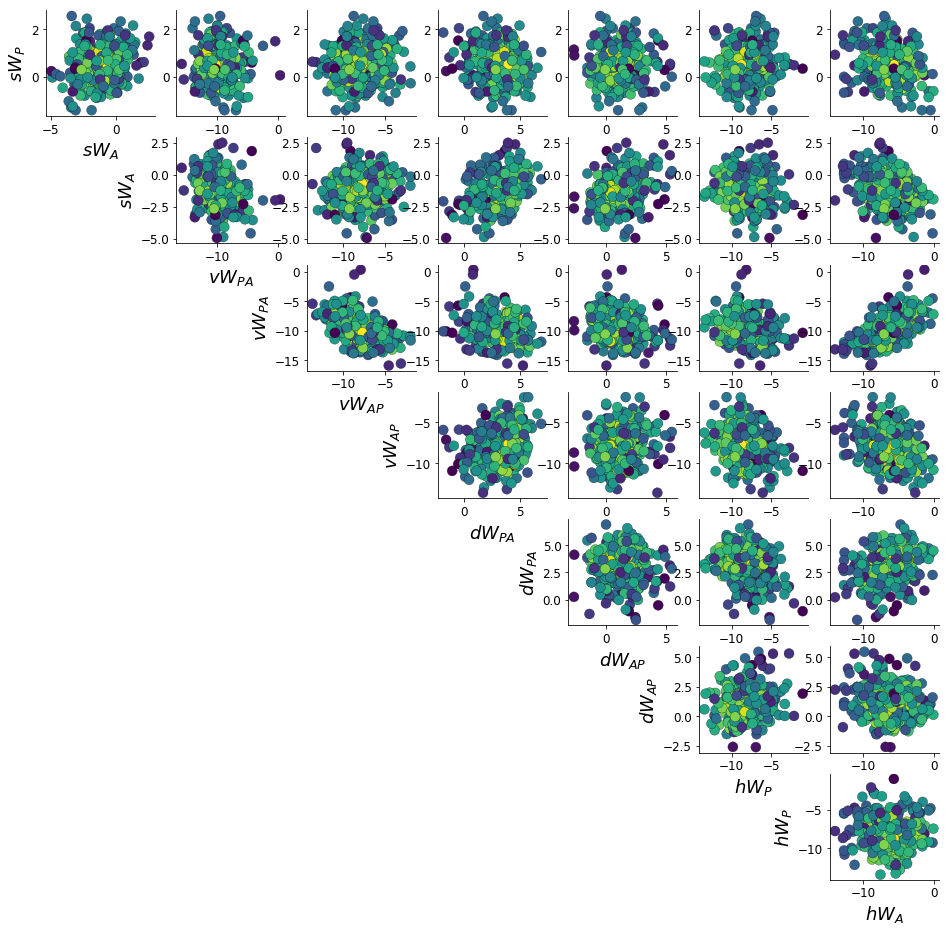

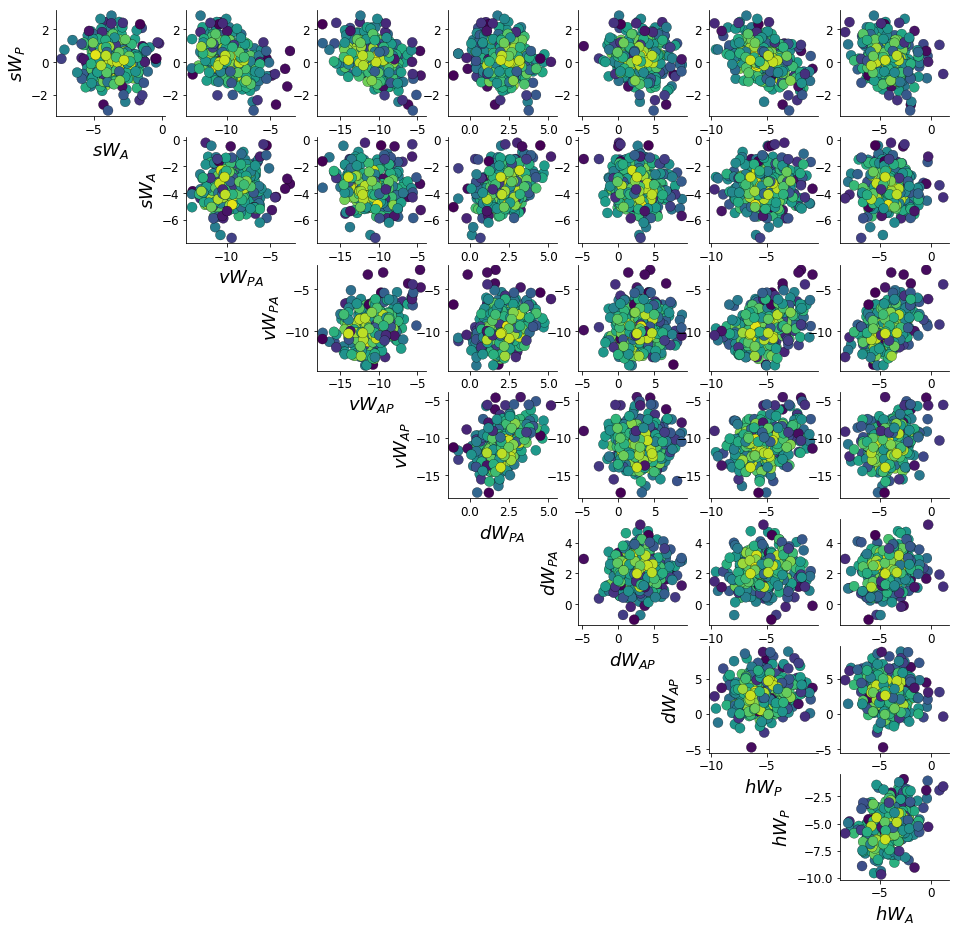

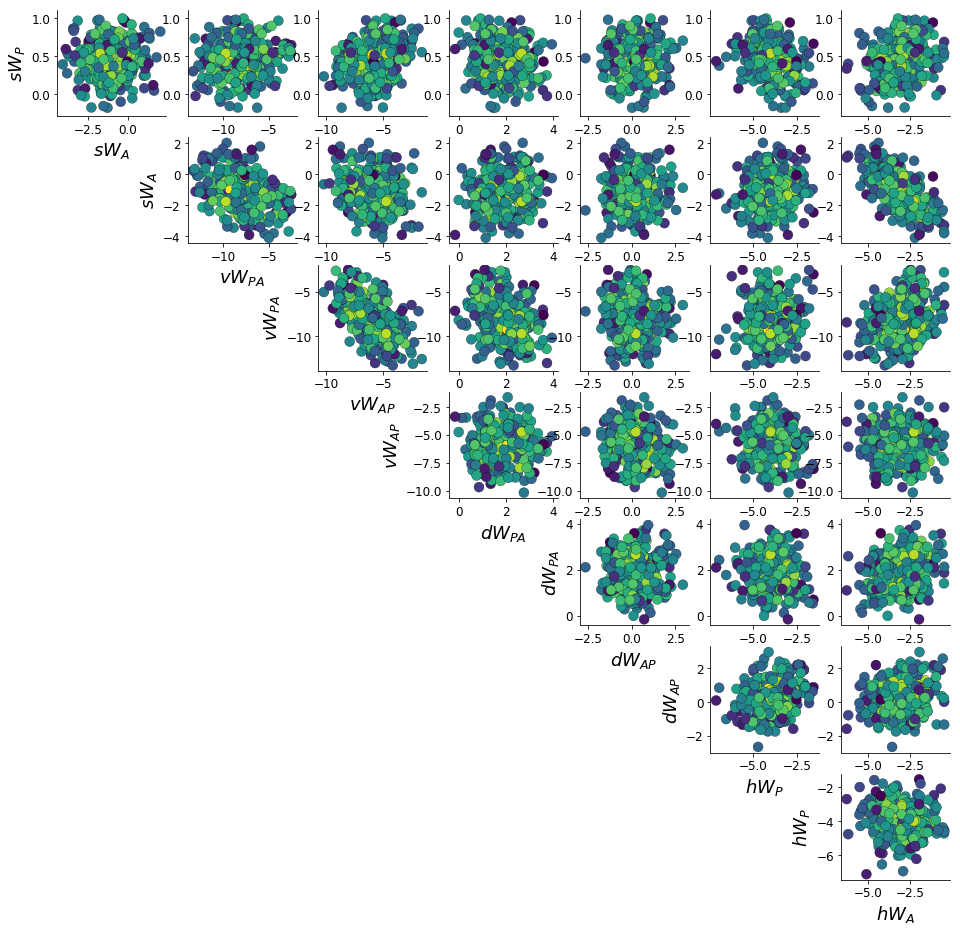

In [7]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
dists, cs, axs = dsn_pairplots(best_models, 'Zs', system, ME_its, \
                      c_str='log_q_z', legendstrs=[], \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(16,16))


ticks None
0
dist (300, 8)
not saving figure
1
dist (300, 8)
not saving figure
2
dist (300, 8)
not saving figure
3
dist (300, 8)
not saving figure
4
dist (300, 8)
not saving figure


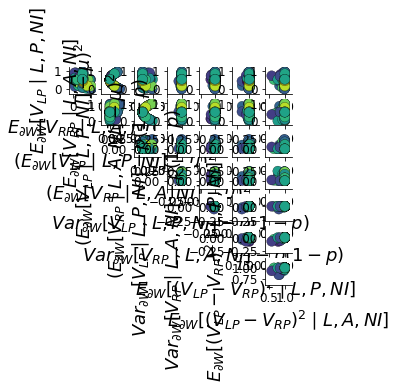

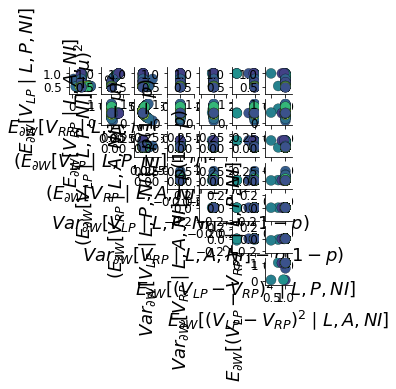

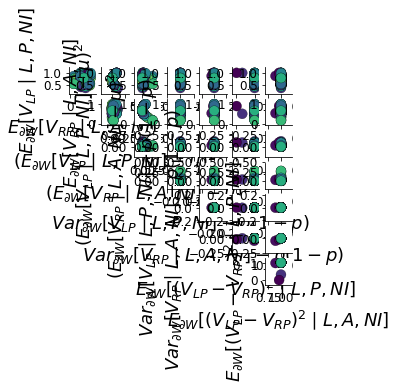

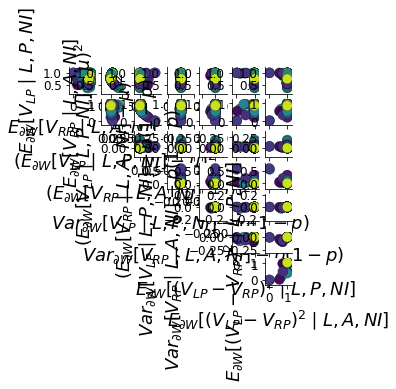

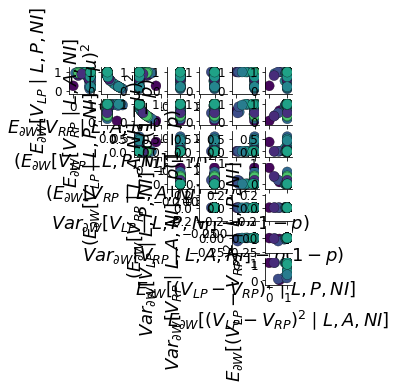

In [8]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
_, cs, axs = dsn_pairplots(best_models, 'T_xs', system, AL_final_its=ME_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(4,4))


In [9]:
num_ps = len(ps)
min_vals = np.zeros((num_ps, system.D,))
max_vals = np.zeros((num_ps, system.D,))

for i in range(num_ps):
    min_vals[i] = np.min(dists[i], 0)
    max_vals[i] = np.max(dists[i], 0)
min_vals = np.min(min_vals, 0)
max_vals = np.max(max_vals, 0)
print(min_vals)
print(max_vals)

[ -5.14560936  -7.36540188 -15.86384275 -17.3395365   -1.86531602
  -4.77403883 -14.48610427 -14.03618737]
[ 6.18125512  9.19328554  1.85040722  4.29055275 11.15727101 14.35185696
  1.54462598  1.18161467]


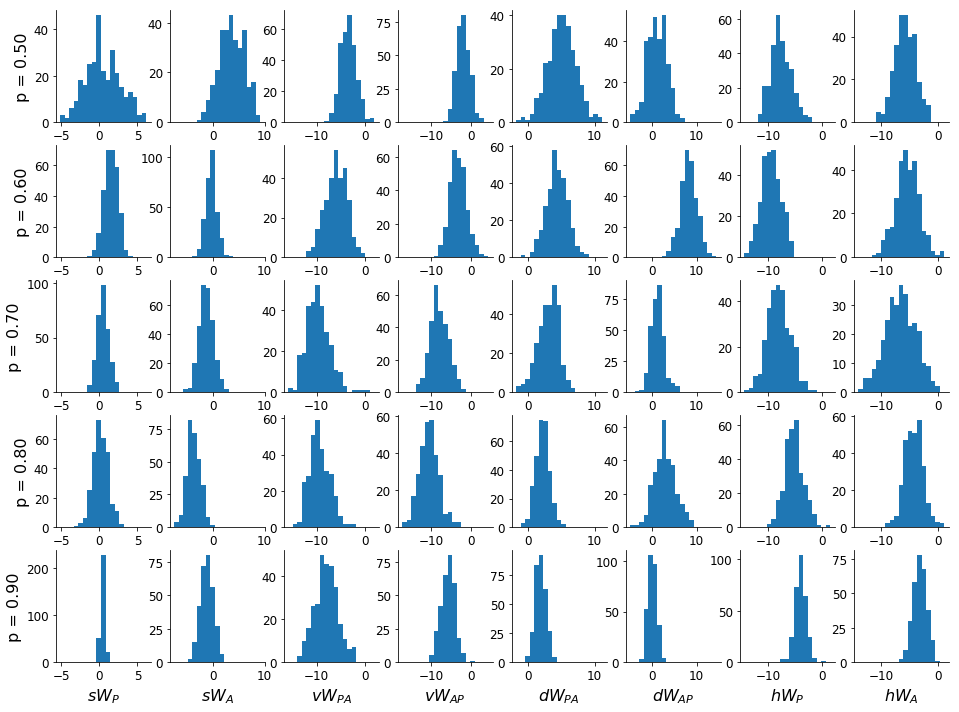

In [10]:
fontsize = 16
fig, axs = plt.subplots(num_ps, system.D, figsize=(16, 12))

for i in range(num_ps):
    for j in range(system.D):
        axs[i][j].hist(dists[i][:,j], bins=np.linspace(min_vals[j], max_vals[j], 20))
        #axs[i][j].set_xlim([min_vals[j], max_vals[j]])
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        
for i in range(num_ps):
    axs[i][0].set_ylabel('p = %.2f' % ps[i], fontsize=fontsize)
    
for i in range(system.D):
    axs[-1][i].set_xlabel(system.z_labels[i], fontsize=fontsize)   
plt.show()

In [11]:
#DTYPE = tf.float64
#Z = tf.placeholder(dtype=DTYPE, shape=(1,None,system.D))
M = 5000

_W = np.random.normal(0.0, 1.0, (1, M, system.D))
print('got rand samps')
sessions = []
savers = []
tf_vars = []

Zs_tf = []
W_mats = []
T_xs_tf = []

for i in range(num_ps):
    p = ps[i]
    best_model = best_models[i]
    ME_it = ME_its[i]
    
    sess = tf.Session()
    new_saver = tf.train.import_meta_graph(best_model + 'model-%d.meta' % (ME_it-1));
    modeldir_i = best_model + 'model-%d' % (ME_it-1)
    new_saver.restore(sess, modeldir_i);
    W = tf.get_collection('W')[0]
    Z = tf.get_collection('Z')[0]
    Z_INV = tf.get_collection('Z_INV')[0]
    log_q_Z = tf.get_collection('log_q_z')[0]
    
    W_mat, I, eta = system.filter_Z(Z)
    T_x = system.compute_suff_stats(Z)
    
    sessions.append(sess)
    savers.append(new_saver)
    tf_vars.append([W, Z, Z_INV, log_q_Z, W_mat])
    
    _Z, _T_x, _W_mat = sess.run([Z, T_x, W_mat], {W:_W})
    
    print(_Z.shape)
    print(_W_mat.shape)
    print(_T_x.shape)
    Zs_tf.append(_Z)
    W_mats.append(_W_mat)
    T_xs_tf.append(_T_x)
    


got rand samps
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=8/model-2
(1, 5000, 8)
(2, 5000, 4, 4)
(1, 5000, 8)
INFO:tensorflow:Restoring parameters from models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=6.00E-01_6.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=7/model-10
(1, 5000, 8)
(2, 5000, 4, 4)
(1, 5000, 8)
INFO:tensorflow:Restoring parameters from models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=7.00E-01_7.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_iso_std=1.0_sigma=1.00_c=2_rs=5/model-5
(1, 5000, 8)
(2, 5000, 4, 4)
(1, 5000, 8)
INFO:tensorflow:Restoring parameters from models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=8.00E-01_8.00E-01_2.25E-02_2.25E-02_0.00E+00_0.00E+00_1.00E+00_1.00E+00_

In [16]:
def get_schur_eigs(W):
    # returns 
    T, Z = scipy.linalg.schur(W)
    b = Z.copy()
    b[b<0.0] = -1
    b[b>0.0] = 1
    modes = 0.25*np.array([[1.0, 1.0, 1.0, 1.0],   # all mode
                          [-1.0, -1.0, 1.0, 1.0], # side mode
                          [1.0, -1.0, -1.0, 1.0], # task mode
                          [-1.0, 1.0, -1.0, 1.0]]) # diag mode
    X = np.abs(np.dot(modes,b))  # (template_mode x z_col)
    eigs = np.zeros((4,))
    for i in range(4):
        z_ind = np.argmax(X[i] == 1.0)
        eigs[i] = T[z_ind, z_ind]
    return eigs
    

In [17]:
eigs = []
for i in range(len(ps)):
    e = np.zeros((M, 4))
    for j in range(M):
        e[j] = get_schur_eigs(W_mats[i][0,j,:,:])
    eigs.append(e)


In [18]:
print(system.T_x_labels)

['$E_{\\partial W}[{V_{LP} \\mid L,P,NI}]$', '$E_{\\partial W}[{V_{RP} \\mid L,A,NI}]$', '$(E_{\\partial W}[{V_{LP} \\mid L,P,NI}]-\\mu)^2$', '$(E_{\\partial W}[{V_{RP} \\mid L,A,NI}]-\\mu)^2$', '$Var_{\\partial W}[{V_{LP} \\mid L,P,NI}] - p(1-p)$', '$Var_{\\partial W}[{V_{RP} \\mid L,A,NI}] - p(1-p)$', '$E_{\\partial W}[{(V_{LP} - V_{RP})^2 \\mid L,P,NI}]$', '$E_{\\partial W}[{(V_{LP} - V_{RP})^2 \\mid L,A,NI}]$']


In [19]:

orange = np.array([204, 102, 0]) / 255.0
purple = np.array([153, 51, 204]) / 255.0
cyan = np.array([0, 153, 204]) / 255.0
colors = ['k', 
          orange,
          purple,
          cyan]


In [48]:
corrs = np.zeros((num_ps, 4, 2))
pvals = np.zeros((num_ps, 4, 2))
for k in range(num_ps):
    _eigs = eigs[k]
    _T_x = T_xs_tf[k]
    for i in range(4):
        for j in range(2):
            _, _, r, p, _ = scipy.stats.linregress(_eigs[:,i], _T_x[0,:,j])
            corrs[k,i,j] = r
            pvals[k,i,j] = 2*p
            #corrs[k,i,j] = np.corrcoef(_eigs[:,i], _T_x[0,:,j])[0,1]

In [64]:
print('correlation of lambda task, and Pro accuracy')
lambda_ind = 2
cue_ind = 0
for i,p in enumerate(ps):
    print('$\lambda_{\\text{task}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(%d\%%))$ & %.2E & %.2E  \\\\ \hline' \
          % (int(100*p), corrs[i,lambda_ind,cue_ind], pvals[i,lambda_ind,cue_ind]))
print('\n')
    
print('correlation of lambda task, and Anti accuracy')
lambda_ind = 2
cue_ind = 1
for i,p in enumerate(ps):
    print('$\lambda_{\\text{task}}$ & $\hat{p}_A$ & $q(z \mid \mathcal{B}(%d\%%))$ & %.2E & %.2E  \\\\ \hline' \
          % (int(100*p), corrs[i,lambda_ind,cue_ind], pvals[i,lambda_ind,cue_ind]))
print('\n')
    
print('correlation of lambda side, and Pro accuracy')
lambda_ind = 1
cue_ind = 0
for i,p in enumerate(ps):
    print('$\lambda_{\\text{side}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(%d\%%))$ & %.2E & %.2E  \\\\ \hline' \
          % (int(100*p), corrs[i,lambda_ind,cue_ind], pvals[i,lambda_ind,cue_ind]))
print('\n')

print('correlation of lambda side, and Anti accuracy')
lambda_ind = 1
cue_ind = 1
for i,p in enumerate(ps):
    print('$\lambda_{\\text{side}}$ & $\hat{p}_A$ & $q(z \mid \mathcal{B}(%d\%%))$ & %.2E & %.2E  \\\\ \hline' \
          % (int(100*p), corrs[i,lambda_ind,cue_ind], pvals[i,lambda_ind,cue_ind]))
print('\n')

correlation of lambda task, and Pro accuracy
$\lambda_{\text{task}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(50\%))$ & -5.09E-02 & 6.32E-04  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(60\%))$ & 1.24E-01 & 3.04E-18  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(70\%))$ & 7.56E-01 & 0.00E+00  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(80\%))$ & 4.59E-01 & 2.76E-259  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_P$ & $q(z \mid \mathcal{B}(90\%))$ & 3.76E-01 & 1.83E-167  \\ \hline


correlation of lambda task, and Anti accuracy
$\lambda_{\text{task}}$ & $\hat{p}_A$ & $q(z \mid \mathcal{B}(50\%))$ & -1.18E-01 & 9.28E-17  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_A$ & $q(z \mid \mathcal{B}(60\%))$ & 4.80E-02 & 1.38E-03  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_A$ & $q(z \mid \mathcal{B}(70\%))$ & 2.08E-01 & 7.17E-50  \\ \hline
$\lambda_{\text{task}}$ & $\hat{p}_A$ & $q(z \mid \mathcal{B}(80\%))$ & 4.84E-0

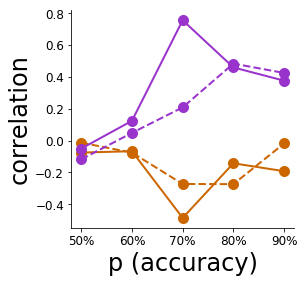

In [49]:
schur_mode_labels = ["all",
                     "side",
                     "task",
                     "diag "]

inds = [1,2]

fontsize = 24
plt.figure(figsize=(4,4))
legendstrs = []
for ind in inds:
    plt.plot(corrs[:,ind,0], '-o', c=colors[ind])
    plt.plot(corrs[:,ind,1], '--o', c=colors[ind])
    schur_mode_label = schur_mode_labels[ind]
    legendstrs.append(r'$r_{S_{%s},p_P}$' % schur_mode_label)
    legendstrs.append(r'$r_{S_{%s},p_A}$' % schur_mode_label)
#plt.legend(legendstrs, fontsize=fontsize, loc=5)
ax = plt.gca()
ax.set_xticks([0,1,2,3,4])
xticklabels = ['%d%%' % int(100*p) for p in ps]
ax.set_xticklabels(xticklabels)
ax.set_xlabel('p (accuracy)', fontsize=fontsize)
ax.set_ylabel('correlation', fontsize=fontsize)
plt.show()

In [22]:
num_ps = len(ps)
min_vals = np.zeros((num_ps, 4,))
max_vals = np.zeros((num_ps, 4,))

for i in range(num_ps):
    min_vals[i] = np.min(eigs[i], 0)
    max_vals[i] = np.max(eigs[i], 0)
min_vals = np.min(min_vals, 0)
max_vals = np.max(max_vals, 0)

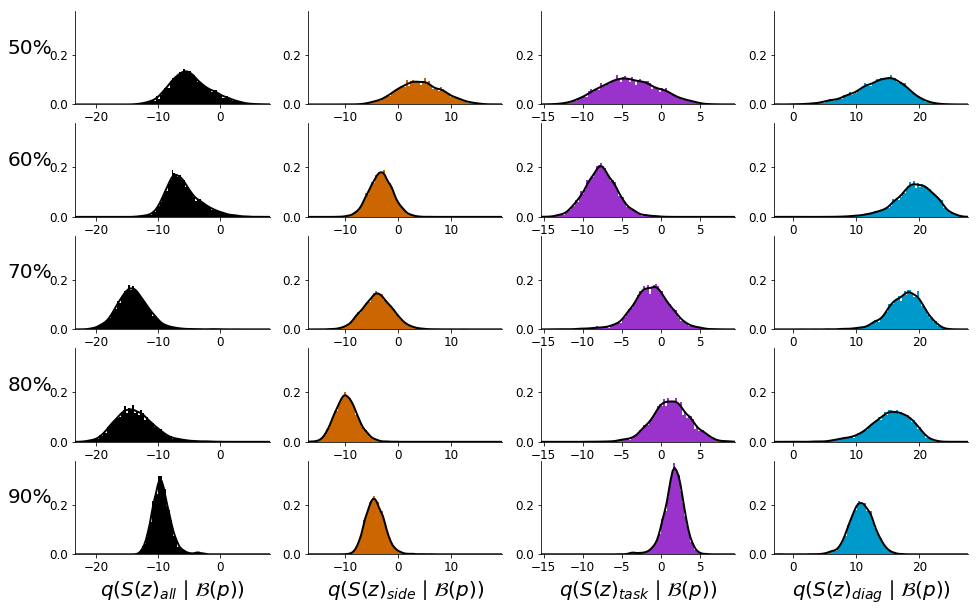

In [23]:
fontsize = 20
fig, axs = plt.subplots(num_ps, 4, figsize=(16, 10))

max_histval = 0.0
ybuf = 0.01
num_bins = 100
for i in range(num_ps):
    for j in range(4):
        bins = np.linspace(min_vals[j], max_vals[j], num_bins)
        contour_x =  np.linspace(min_vals[j], max_vals[j], num_bins)
        n, _, _ = axs[i][j].hist(eigs[i][:,j], bins=bins, color=colors[j],
                       histtype='bar', density=True)
        # contour
        kde = scipy.stats.gaussian_kde(eigs[i][:,j])
        axs[i][j].plot(contour_x, kde(contour_x), 'k-')
        
        
        axs[i][j].set_xlim([min_vals[j], max_vals[j]])
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        
        # update maxval
        max_ij = np.max(n)
        if (max_ij > max_histval):
            max_histval = max_ij
        
for i in range(num_ps):
    axs[i][0].set_ylabel('%d%%' % int(100*ps[i]), fontsize=fontsize, rotation=0, labelpad=20)
    for j in range(4):
        axs[i][j].set_ylim([0, max_histval+ybuf])
    
for i in range(4):
    axs[-1][i].set_xlabel(r'$q(S(z)_{%s} \mid \mathcal{B}(p))$' % schur_mode_labels[i], fontsize=fontsize)   
plt.savefig('DSN_dists.png', dpi=300)
plt.show()

In [38]:
M_test = 100
N = M //M_test

mean_eigs = np.zeros((num_ps,N,4))
for k in range(num_ps):
    for i in range(N):
        start_ind = i*M_test
        end_ind = (i+1)*M_test
        mean_eigs[k,i,:] = np.mean(eigs[k][start_ind:end_ind,:], axis=0)



(5000, 4) 0 100
(5000, 4) 100 200
(5000, 4) 200 300
(5000, 4) 300 400
(5000, 4) 400 500
(5000, 4) 500 600
(5000, 4) 600 700
(5000, 4) 700 800
(5000, 4) 800 900
(5000, 4) 900 1000
(5000, 4) 1000 1100
(5000, 4) 1100 1200
(5000, 4) 1200 1300
(5000, 4) 1300 1400
(5000, 4) 1400 1500
(5000, 4) 1500 1600
(5000, 4) 1600 1700
(5000, 4) 1700 1800
(5000, 4) 1800 1900
(5000, 4) 1900 2000
(5000, 4) 2000 2100
(5000, 4) 2100 2200
(5000, 4) 2200 2300
(5000, 4) 2300 2400
(5000, 4) 2400 2500
(5000, 4) 2500 2600
(5000, 4) 2600 2700
(5000, 4) 2700 2800
(5000, 4) 2800 2900
(5000, 4) 2900 3000
(5000, 4) 3000 3100
(5000, 4) 3100 3200
(5000, 4) 3200 3300
(5000, 4) 3300 3400
(5000, 4) 3400 3500
(5000, 4) 3500 3600
(5000, 4) 3600 3700
(5000, 4) 3700 3800
(5000, 4) 3800 3900
(5000, 4) 3900 4000
(5000, 4) 4000 4100
(5000, 4) 4100 4200
(5000, 4) 4200 4300
(5000, 4) 4300 4400
(5000, 4) 4400 4500
(5000, 4) 4500 4600
(5000, 4) 4600 4700
(5000, 4) 4700 4800
(5000, 4) 4800 4900
(5000, 4) 4900 5000
(5000, 4) 0 100
(5000

In [46]:
from scipy.stats import mannwhitneyu
print('lambda task')
u, p = mannwhitneyu(mean_eigs[1,:,2], mean_eigs[2,:,2], alternative='less')
print('60 < 70', u, p)
u, p = mannwhitneyu(mean_eigs[2,:,2], mean_eigs[3,:,2], alternative='less')
print('70 < 80', u, p)
u, p = mannwhitneyu(mean_eigs[3,:,2], mean_eigs[4,:,2], alternative='less')
print('80 < 90', u, p)

print('lambda side')
u, p = mannwhitneyu(mean_eigs[1,:,1], mean_eigs[0,:,1], alternative='less')
print('60 < 50', u, p)
u, p = mannwhitneyu(mean_eigs[2,:,1], mean_eigs[0,:,1], alternative='less')
print('70 < 50', u, p)
u, p = mannwhitneyu(mean_eigs[3,:,1], mean_eigs[0,:,1], alternative='less')
print('80 < 50', u, p)
u, p = mannwhitneyu(mean_eigs[4,:,1], mean_eigs[0,:,1], alternative='less')
print('80 < 50', u, p)

lambda task
60 < 70 0.0 3.533035965194466e-18
70 < 80 0.0 3.533035965194466e-18
80 < 90 171.0 5.229001919124404e-14
lambda side
60 < 50 0.0 3.533035965194466e-18
70 < 50 0.0 3.533035965194466e-18
80 < 50 0.0 3.533035965194466e-18
80 < 50 0.0 3.533035965194466e-18


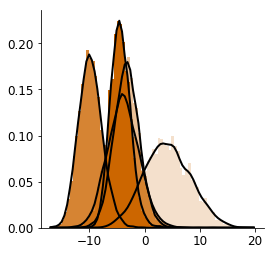

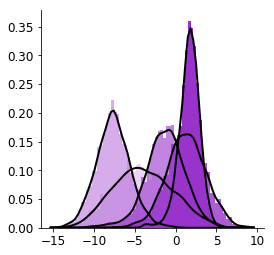

In [24]:
alphas = np.linspace(0.2, 1.0, 5)

colors = ['k', 
          orange,
          purple,
          cyan]

fontsize = 20

inds = [1,2]

for j in inds:
    fig = plt.figure(figsize=(4,4))

    max_histval = 0.0
    ybuf = 0.01
    num_bins = 75
    for i in range(num_ps):
        alpha = alphas[i]
        color = np.concatenate((colors[j], np.array([alpha])), axis=0)
        bins = np.linspace(min_vals[j], max_vals[j], num_bins)
        contour_x =  np.linspace(min_vals[j], max_vals[j], num_bins)
        n, _, _ = plt.hist(eigs[i][:,j], bins=bins, color=color,
                       histtype='bar', density=True)
        # contour
        kde = scipy.stats.gaussian_kde(eigs[i][:,j])
        plt.plot(contour_x, kde(contour_x), 'k-')

        # update maxval
        max_ij = np.max(n)
        if (max_ij > max_histval):
            max_histval = max_ij

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.savefig('DSN_dists.png', dpi=300)
    plt.show()

In [25]:
# plot the mean trends
Eigs = np.array(eigs)
eigs_mean = np.mean(Eigs, 1)
eigs_var = np.var(Eigs, 1)

KLs = np.zeros((num_ps-1, 4))
for j in range(4):
    for i in range(num_ps-1):
        # calculate KL between each p_targ
        mu_1 = eigs_mean[i,j]
        mu_2 = eigs_mean[i+1, j]
        sigma_1 = np.sqrt(eigs_var[i, j])
        sigma_2 = np.sqrt(eigs_var[i+1, j])
        KLs[i,j] = np.log(sigma_2/sigma_1) + \
                  (np.square(sigma_1) + np.square(mu_1 - mu_2)) / (2*np.square(sigma_2)) - 0.5

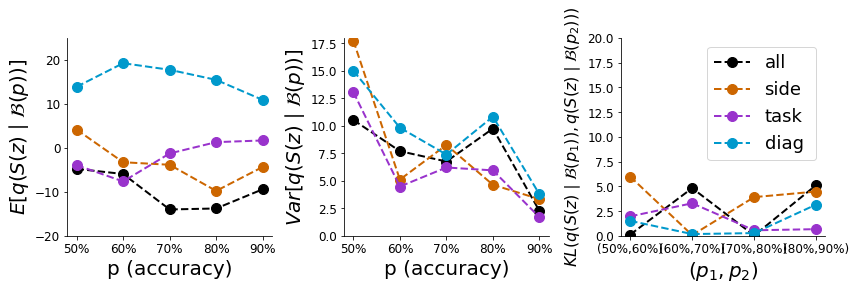

In [26]:
fontsize = 20
ps_x = 100*np.array(ps)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(4):
    axs[0].plot(ps_x, eigs_mean[:,i], '--o', color=colors[i])
    axs[1].plot(ps_x, eigs_var[:,i], '--o', color=colors[i])
    axs[2].plot(np.arange(1,5), KLs[:,i], '--o', color=colors[i])

axs[2].set_xticks([1,2,3,4])
axs[2].set_xticklabels(['(50%,60%)', '(60%,70%)', '(70%,80%)', '(80%,90%)'])
for i in range(3):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
for i in range(2):
    axs[i].set_xlabel('p (accuracy)', fontsize=fontsize)
    axs[i].set_xticks([50, 60, 70, 80, 90])
    axs[i].set_xticklabels(['50%', '60%', '70%', '80%', '90%'])
axs[2].set_xlabel(r'$(p_1, p_2)$', fontsize=fontsize)
    
axs[0].set_ylabel(r'$E[q(S(z) \mid \mathcal{B}(p))]$', fontsize=fontsize)
axs[1].set_ylabel(r'$Var[q(S(z) \mid \mathcal{B}(p))]$', fontsize=fontsize)
axs[2].set_ylabel(r'$KL(q(S(z) \mid \mathcal{B}(p_1)), q(S(z) \mid \mathcal{B}(p_2)))$', fontsize=fontsize-4)

axs[0].set_ylim([-20, 25])
axs[1].set_ylim([0, 18])
axs[2].set_ylim([0, 20])

axs[2].legend(schur_mode_labels, fontsize=fontsize-2)

plt.tight_layout()
plt.savefig('DSN_moments.png', dpi=300)
plt.show()

In [27]:
print(eigs[0].shape)
for i in range(len(ps)):
    print('p = %.2f' % ps[i])
    print('all mode %.1f%% positive' % (100*np.sum(eigs[i][:,0] > 0.0) / M))
    print('side mode %.1f%% positive' % (100*np.sum(eigs[i][:,1] > 0.0) / M))
    print('task mode %.1f%% positive' % (100*np.sum(eigs[i][:,2] > 0.0) / M))
    print('diag mode %.1f%% positive' % (100*np.sum(eigs[i][:,3] > 0.0) / M))
    print('')

(5000, 4)
p = 0.50
all mode 8.7% positive
side mode 83.2% positive
task mode 15.5% positive
diag mode 99.9% positive

p = 0.60
all mode 3.5% positive
side mode 7.4% positive
task mode 0.1% positive
diag mode 100.0% positive

p = 0.70
all mode 0.0% positive
side mode 8.7% positive
task mode 29.3% positive
diag mode 100.0% positive

p = 0.80
all mode 0.0% positive
side mode 0.0% positive
task mode 70.6% positive
diag mode 100.0% positive

p = 0.90
all mode 0.0% positive
side mode 1.5% positive
task mode 91.3% positive
diag mode 100.0% positive



In [28]:
print(eigs[0].shape)
modes = ['all', 'side', 'task', 'diag']
for j in range(4):
    percs = []
    for i in range(len(ps)):
        percs.append(100*np.sum(eigs[i][:,j] > 0.0) / M)
    print('%s mode %.1f%% positive' % (modes[j], sum(percs)/len(ps)))

(5000, 4)
all mode 2.5% positive
side mode 20.2% positive
task mode 41.3% positive
diag mode 100.0% positive
